In [1]:
import os
import arlpy
import csv
import mmap
import pickle
import numpy as np
import pandas as pd
import datetime as dt
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
#from pyearth import Earth#conda install sklearn-contrib-py-earth

np.warnings.filterwarnings('ignore') #Runtime warning
%matplotlib inline

ModuleNotFoundError: No module named 'arlpy'

In [2]:
#Header of csv: 'Date[0],Time[1],Depth of Airgun(m)[2],Depth of Reciever(m)[3],X Airgun[4],Y Airgun[5],Z Airgun[6],X_R1[7],Y_R1[8],Z_R1[9],SEL1[10],RMS1[11],SEL2[12],RMS2[13],SEL3[14],RMS3[15],SEL4[16],RMS4[17],SEL_full[18],RMS_full[19],T90_1[20],T90_2[21],T90_3[22],T90_4[23],T90_full[24]
def prepData(x_data,y_data,path,skiplist):
    csv_train_path = path
    files = os.listdir(csv_train_path)
    dataTrain = {}
    x_data2 = x_data
    y_data2 = y_data
            
    file = open(skiplist, 'rb',0)
    s = mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ)
    
    for filename in sorted(files):
        if s.find(str.encode(filename)) == -1:
            dirname = csv_train_path + filename
            dataTrain = pd.read_csv(dirname)
            dataTrain = dataTrain.rename(columns={'Depth of Airgun(m)': 'ag_depth','Depth of Reciever(m)': 'hyd_depth'})
            dataTrain = dataTrain[(dataTrain.hyd_depth != -99999)]    
            ag_x = dataTrain['X Airgun']
            ag_y = dataTrain['Y Airgun']
            ag_z = dataTrain['Z Airgun']
            hyd_x = dataTrain['X_R1'] #relative to ag_x
            hyd_y = dataTrain['Y_R1'] #relative to ag_y
            hyd_z = dataTrain['Z_R1'] #relative to ag_z
            r_train = np.sqrt(np.square(hyd_x) + np.square(hyd_y) + np.square(hyd_z))
            logr_train = np.log10(np.sqrt(np.square(hyd_x) + np.square(hyd_y) + np.square(hyd_z)))
            dataTrain = dataTrain.assign(r_train = r_train,logr_train = logr_train,filename = filename)
            dataTrain = dataTrain.dropna(axis=0, how='any')

     #      outliers
            sel_dif = {}
            sel_dif = dataTrain['SEL_full'].diff()
            sel_dif2 = sel_dif.dropna(axis=0, how='any')
            sel_thres = np.abs(np.mean(np.abs(sel_dif2)))
            sel_dif = sel_dif[np.abs(sel_dif.values) < sel_thres]
            dataTrain = dataTrain.loc[sel_dif.index]

     #       rms_dif = {}
     #       rms_dif = dataTrain['RMS_full'].diff()
     #       rms_dif2 = rms_dif.dropna(axis=0, how='any')
     #       rms_thres = np.abs(np.mean(np.abs(rms_dif2)))
     #       rms_dif = rms_dif[np.abs(rms_dif.values) < rms_thres]
     #       dataTrain = dataTrain.loc[rms_dif.index]        

            x_data2 = x_data2.append(dataTrain[['ag_depth', 'hyd_depth','r_train','logr_train']],ignore_index=True)
            y_data2 = y_data2.append(dataTrain[['SEL_full','RMS_full']], ignore_index=True)
     #       data = data.append(dataTrain[['filename','ag_depth', 'hyd_depth','logr_train','r_train','RMS_full','SEL_full']],ignore_index=True)
     #   else:
     #       print('rejected:'+filename)
    return [x_data2,y_data2]

def pickle2(filename,x_data,y_data):
    outfile = open(filename,'wb')
    pickle.dump({'X': x_data, 'SEL': y_data['SEL_full'], 'RMS': y_data['RMS_full']},outfile)
    outfile.close()
    return;

In [3]:
##from google.colab import drive
##
##drive.mount('/content/gdrive')#, force_remount=True) 
##
##infile = open('/content/gdrive/My Drive/all_lines(pruned).pickle', 'rb')
##data = pickle.load(infile, encoding='bytes')

infile = open('all_lines(pruned).pickle','rb')##
#infile = open('all_lines.pickle','rb')
data = pickle.load(infile, encoding='bytes')

In [4]:
#SEL
#draw from the pickle
infile = open('all_lines(pruned).pickle','rb')
#infile = open('all_lines.pickle','rb')
data = pickle.load(infile, encoding='bytes')
#x_train, x_test, y_train, y_test = train_test_split(data['X'],data['SEL'],test_size=0.1,shuffle=True)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data['X'],data['SEL'],test_size=0.1,shuffle=True)#load
#https://stackoverflow.com/questions/43357507/pca-memory-error-in-sklearn-alternative-dim-reduction
#SVD
svd = decomposition.TruncatedSVD(n_components=3, algorithm='randomized')#arpack
svd.fit(x_train)
#print(svd.explained_variance_ratio_.sum())
x_train_pca = svd.transform(x_train)
x_test_pca = svd.transform(x_test)

#KPCA
#kpca = KernelPCA( kernel='linear',alpha=1.0)#n_components=4,
#kpca.fit(x_train)
#x_test_pca = kpca.transform(x_test)
#x_train_pca = kpca.transform(x_train)

#PCA
#pca = PCA(n_components=4)
#pca.fit(x_train)
#x_train_pca = pca.transform(x_train)
#x_test_pca = pca.transform(x_test)

In [6]:
#Random Forest
rf_sel = RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0, max_features="sqrt",max_depth=10)
rf_sel.fit(x_train,y_train)

rf_sel_pca = RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0, max_features="sqrt",max_depth=10)
rf_sel_pca.fit(x_train_pca,y_train)

y_pred_sel = rf_sel.predict(x_test)
y_pred_sel_pca = rf_sel_pca.predict(x_test_pca)

print('==========Untransformed==========')
print("Total Mean squared error: \n",mean_squared_error(y_test,y_pred_sel))
print("Out-of-bag (OOB) error: \n",rf_sel.oob_score_)
print("Test data R-2 score: \n",r2_score(y_test,y_pred_sel))
print('==========PCA transform==========')
print("Total Mean squared error: \n",mean_squared_error(y_test,y_pred_sel_pca))
print("Out-of-bag (OOB) error: \n",rf_sel_pca.oob_score_)
print("Test data R-2 score: \n",r2_score(y_test,y_pred_sel_pca))

==========Untransformed==========
Total Mean squared error: 
 5.375511823547746
Out-of-bag (OOB) error: 
 -8.465331949529768
Test data R-2 score: 
 0.80861696079474
==========PCA transform==========
Total Mean squared error: 
 6.392293746605822
Out-of-bag (OOB) error: 
 -8.504014242379027
Test data R-2 score: 
 0.7724167214442488


In [7]:
print("Models for RMS")
x_train, x_test, y_train, y_test = train_test_split(data['X'],data['RMS'],test_size=0.1,shuffle=True)
print("=====================Linear=====================")
reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
# Train the model using the training sets
linreg_model = reg.fit(x_train, y_train)
print('Coefficients (slope): \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

 
y_pred = linreg_model.predict(x_test)

R2 = reg.score(x_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x_test_subset = x_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model.predict(x_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================2nd degree poly================")#2nd degree polynomial
poly = PolynomialFeatures(degree=2)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================3rd degree poly================")#3rd degree polynomial
poly = PolynomialFeatures(degree=3)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================4th degree poly================")#3rd degree polynomial
poly = PolynomialFeatures(degree=4)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

Models for RMS
=====================Linear=====================
Coefficients (slope): 
 [-4.40144935e-03  2.51866525e-03  8.59813200e-05 -9.89224371e+00]
Intercept: 
 197.74667727798806
R^2 score: 0.33 

Total Mean squared error: 28.87 

Subspace Mean squared error: 23.44 

================2nd degree poly================
Coefficients (slope): 
 [ 0.00000000e+00 -4.96198272e-02  3.60859761e-02 -1.03361975e+00
 -1.05339445e+03 -1.43103098e-07  1.09782191e-06 -1.11869526e-06
  1.38641891e-02 -3.88876313e-07  2.26277839e-06 -1.18528931e-02
 -5.91086978e-06  2.47287193e-01  2.48619827e+02]
Intercept: 
 1394.505592726589
R^2 score: 0.47 

Total Mean squared error: 22.71 

Subspace Mean squared error: 18.75 

================3rd degree poly================
Coefficients (slope): 
 [ 8.50987230e-04 -2.09464803e-01  7.38467441e-01 -1.87885510e+02
 -6.90803484e+02 -1.78779898e-06  4.24749546e-05  2.16759457e-04
  1.49986825e-01 -1.36624548e-05 -6.60656615e-04 -6.51598347e-01
  4.30337425e-03  9.3

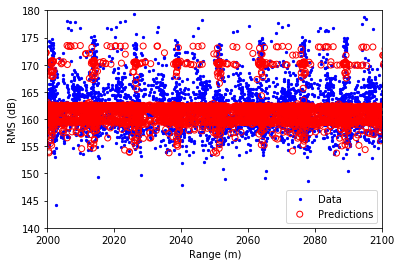

In [8]:
plt.scatter(x_test['r_train'], y_test,  color='blue', s=5, label='Data')
plt.scatter(x_test['r_train'], y_pred,  color='none', edgecolors='r', label='Predictions')
plt.xlabel("Range (m)")
plt.ylabel("RMS (dB)")
plt.ylim(140,180)
plt.xlim(2000,2100)
x = plt.legend()

In [9]:
print("Models for SEL")
x_train, x_test, y_train, y_test = train_test_split(data['X'],data['SEL'],test_size=0.1,shuffle=True)
print("=====================Linear=====================")
reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
# Train the model using the training sets
linreg_model = reg.fit(x_train, y_train)
print('Coefficients (slope): \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

 
y_pred = linreg_model.predict(x_test)

R2 = reg.score(x_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x_test_subset = x_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model.predict(x_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================2nd degree poly================")#2nd degree polynomial
poly = PolynomialFeatures(degree=2)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================3rd degree poly================")#3rd degree polynomial
poly = PolynomialFeatures(degree=3)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

print("================4th degree poly================")#4th degree polynomial
poly = PolynomialFeatures(degree=4)
reg2 = linear_model.LinearRegression(fit_intercept=True, normalize=False)
x2_train = poly.fit_transform(x_train)
x2_test = poly.fit_transform(x_test)

linreg_model2 = reg2.fit(x2_train, y_train)
print('Coefficients (slope): \n', reg2.coef_)
print('Intercept: \n', reg2.intercept_)
 
y_pred = linreg_model2.predict(x2_test)

R2 = reg2.score(x2_test, y_test)
print('R^2 score: %.2f \n' %R2)
err_total = mean_squared_error(y_test, y_pred)
print("Total Mean squared error: %.2f \n" %err_total)
 
x2_test_subset = x2_test[100:200]
y_test_subset = y_test[100:200]
y_pred_subset = linreg_model2.predict(x2_test_subset)
err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
print("Subspace Mean squared error: %.2f \n" %err_subspace)

Models for SEL
=====================Linear=====================
Coefficients (slope): 
 [-2.94393861e-03  1.73482254e-03 -4.57232362e-04 -7.81455084e+00]
Intercept: 
 189.59860485741711
R^2 score: 0.53 

Total Mean squared error: 13.09 

Subspace Mean squared error: 13.82 

================2nd degree poly================
Coefficients (slope): 
 [ 0.00000000e+00 -3.57933168e-02  2.00871160e-02 -5.56798443e-01
 -5.38968367e+02 -3.33254097e-07  5.65291608e-07 -6.52055310e-07
  1.02002898e-02 -2.82771664e-07  1.14542801e-06 -6.22941168e-03
 -3.13279497e-06  1.33235297e-01  1.27802195e+02]
Intercept: 
 796.9778818516655
R^2 score: 0.66 

Total Mean squared error: 9.62 

Subspace Mean squared error: 9.54 

================3rd degree poly================
Coefficients (slope): 
 [-6.36725714e-08  1.83113196e-01  4.52283614e-02 -1.18841794e+02
 -5.28032649e+02 -3.29209779e-05  4.82528959e-05 -1.28742026e-04
 -1.66646379e-01 -6.33510307e-06 -1.21623075e-04 -6.29876277e-02
  3.25660066e-03  6.022

In [0]:
#this takes a while
#mars = Earth()
#mars.fit(x_train,y_train)
#
#filename = 'mars_sel.pickle'
#outfile = open(filename,'wb')
#
#pickle.dump(mars,outfile)
#outfile.close()

#print("=======Multivariate Adaptive Regression Splines=======")
##https://contrib.scikit-learn.org/py-earth/content.html
#infile = open('mars_sel.pickle','rb')
#mars = pickle.load(infile)
#y_pred = mars.predict(x_test)
#
#R2 = mars.grsq_#MARS score equivalent
#print('R^2 score: %.2f \n' %R2)
#err_total = mean_squared_error(y_test, y_pred)
#print("Total Mean squared error: %.2f \n" %err_total)
# 
#x_test_subset = x_test[100:200]
#y_test_subset = y_test[100:200]
#y_pred_subset = mars.predict(x_test_subset)
#err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
#print("Subspace Mean squared error: %.2f \n" %err_subspace)

#this takes a while

#mars = Earth()
#mars.fit(x_train,y_train)
#
#filename = 'mars_rms.pickle'
#outfile = open(filename,'wb')
#
#pickle.dump(mars,outfile)
#outfile.close()
#

#print("=======Multivariate Adaptive Regression Splines=======")
##https://contrib.scikit-learn.org/py-earth/content.html
#infile = open('mars_rms.pickle','rb')
#mars = pickle.load(infile)
#y_pred = mars.predict(x_test)
#
#R2 = mars.grsq_#MARS score equivalent
#print('R^2 score: %.2f \n' %R2)
#err_total = mean_squared_error(y_test, y_pred)
#print("Total Mean squared error: %.2f \n" %err_total)
# 
#x_test_subset = x_test[100:200]
#y_test_subset = y_test[100:200]
#y_pred_subset = mars.predict(x_test_subset)
#err_subspace = mean_squared_error(y_test_subset, y_pred_subset)
#print("Subspace Mean squared error: %.2f \n" %err_subspace)

In [0]:
#skiplist = 'C:\SPB_Data\pcbenv\skip.txt'#bad data
#
#whole data set
#path1 = r'D:\Machine Learning\NewCSV\CSV1\Line_01_(RMS_and_SEL)\\'
#path2 = r'D:\Machine Learning\NewCSV\CSV1\Line_02_(RMS_and_SEL)\\'
#path3 = r'D:\Machine Learning\NewCSV\CSV1\Line_03_(RMS_and_SEL)\\'
#path4 = r'D:\Machine Learning\NewCSV\CSV1\Line_04_(RMS_and_SEL)\\'
#path5 = r'D:\Machine Learning\NewCSV\CSV1\Line_05_(RMS_and_SEL)\\'
#path6 = r'D:\Machine Learning\NewCSV\CSV1\Line_06_(RMS_and_SEL)\\'
#path7 = r'D:\Machine Learning\NewCSV\CSV1\Line_07_(RMS_and_SEL)\\'
#path8 = r'D:\Machine Learning\NewCSV\CSV1\Line_08_(RMS_and_SEL)\\'
#path9 = r'D:\Machine Learning\NewCSV\CSV1\Line_09_(RMS_and_SEL)\\'
#path10 = r'D:\Machine Learning\NewCSV\CSV1\Line_10_(RMS_and_SEL)\\'
#path11 = r'D:\Machine Learning\NewCSV\CSV1\Line_11_(RMS_and_SEL)\\'
#pathAT = r'D:\Machine Learning\NewCSV\CSV1\Line_AT_(RMS_and_SEL)\\'
#
#[x_data,y_data] = prepData(pd.DataFrame(),pd.Series(),path1,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path2,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path3,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path4,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path5,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path6,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path7,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path8,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path9,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path10,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,path11,skiplist)
#[x_data,y_data] = prepData(x_data,y_data,pathAT,skiplist)
#pickle2('all_lines(pruned,rms).pickle',x_data,y_data)